In [120]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [121]:
# Importing necessary libraries
import numpy as np
import os
import imageio 
from PIL import Image
from skimage.transform import resize
import datetime

We set the random seed so that the results don't vary drastically.

In [122]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

Reading the folder names for training and validation and setting batchsize

In [4]:
train_doc = np.random.permutation(open('/kaggle/input/motion-gesture/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/motion-gesture/Project_data/val.csv').readlines())
batch_size = 40

In [59]:
# Defining function for Cropping and Resizing the images
def cropAndResize(image,HEIGHT_DIMENSION,WIDTH_DIMENSION):
    #The images are of 2 different shape and the Model will throw error if the inputs in a batch have different shapes.
    # Cropping images
    if abs(image.size[0]-image.size[1])%2==0 and image.size[0]!=image.size[1]:
        dimension_diff=abs(image.size[0]-image.size[1])
        cropping_ratio=dimension_diff//2
        if image.size[0]>image.size[1]:
            cropping_ratio_e=cropping_ratio+image.size[1]
            image=image.crop((cropping_ratio,0,cropping_ratio_e,image.size[1]))
        elif image.size[0]<image.size[1]:
            cropping_ratio_e=cropping_ratio+image.size[0]
            image=image.crop((cropping_ratio,0,cropping_ratio_e,image.size[0]))
                    
    # Resizing images
    if image.size[0]>100 or image.size[1]>100:
        image=image.resize((100, 100))
    return image

In [129]:
(len(train_doc)%batch_size)

23

### Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames.experimenting with img_idx, y,z and normalization such that you get high accuracy.

In [130]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [1,3,5,6,7,9,11,13,15,17,18,19,21,23,24,25,27,29]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #Cropping and Resize images  
                    image_resized = cropAndResize(image,100,100)
                    image_resized=(image_resized-np.min(image_resized))/(np.max(image_resized)-np.min(image_resized))
                    
                    batch_data[folder,idx,:,:,0] = image_resized[:,:,0]      #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_resized[:,:,1]        #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_resized[:,:,2]        #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if((len(folder_list)%batch_size)!=0):
            batch_size = len(folder_list)-(batch_size*num_batches)
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    # Cropping and Resizing image
                    image_resized = cropAndResize(image,100,100)
                    image_resized=(image_resized-np.min(image_resized))/(np.max(image_resized)-np.min(image_resized))
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = image_resized[:,:,0]       #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_resized[:,:,1]       #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_resized[:,:,2]       #normalise and feed in the image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [131]:
# Creating fuction to plot results
from matplotlib import pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [132]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/motion-gesture/Project_data/train'
val_path = '/kaggle/input/motion-gesture/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


# Model 1: mobilenet transfer learning

In [133]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,LSTM,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers

img_idx =  [1,3,5,6,7,9,11,13,15,17,18,19,21,23,24,25,27,29]
input_shape = (len(img_idx), 100, 100, 3)
np.random.seed(30)

#write your model here
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
 
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(GRU(64))
        
model.add(Dense(64,activation='relu'))
        
model.add(Dense(5, activation='softmax'))

In [134]:
optimiser =tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_41 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 batch_normalization_18 (Bat  (None, 18, 3, 3, 1024)   4096      
 chNormalization)                                                
                                                                 
 time_distributed_42 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 gru_12 (GRU)                (None, 64)              

In [135]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

### Creating a direct

In [136]:
model_name = 'mobile_net' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=6) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [137]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [138]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_29/1787904139.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /kaggle/input/motion-gesture/Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.0851 - categorical_accuracy: 0.5520Source path =  /kaggle/input/motion-gesture/Project_data/val ; batch size = 40

Epoch 1: val_loss improved from inf to 1.41054, saving model to mobile_net_2023-06-2809_58_55.251886/model-00001-1.08512-0.55204-1.41054-0.48000.h5
17/17 [==============================] - 91s 4s/step - loss: 1.0851 - categorical_accuracy: 0.5520 - val_loss: 1.4105 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.4175 - categorical_accuracy: 0.8465
Epoch 2: val_loss improved from 1.41054 to 0.94330, saving model to mobile_net_2023-06-2809_58_55.251886/model-00002-0.41749-0.84655-0.94330-0.55000.h5
17/17 [==============================] - 44s 3s/step - loss: 0.4175 - categorical_accuracy: 0.8465 - val_loss: 0.9433 - val_categorical_accuracy: 0.5500 - lr: 0.0

In [139]:
plot(history)

# Model 2: Conv3D 

In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
Input_shape = (18, 100, 100, 3)
model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same',
                 input_shape=Input_shape))
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(128, (3, 3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(256, (3, 3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(256, (3, 3,3),padding="same"))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [24]:
optimiser =tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_2 (Batc  (None, 9, 50, 50, 128)   512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 9, 50, 50, 128)   

In [25]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [27]:
model_name = 'Conv3D_model2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [28]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_29/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_29/3587691246.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /kaggle/input/motion-gesture/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 64.8823 - categorical_accuracy: 0.1429Source path =  /kaggle/input/motion-gesture/Project_data/val ; batch size = 50

Epoch 1: saving model to Conv3D_model2_2023-06-2804_13_56.602750/model-00001-64.88235-0.14286-114.86981-0.50000.h5
14/14 [==============================] - 9s 354ms/step - loss: 64.8823 - categorical_accuracy: 0.1429 - val_loss: 114.8698 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 28.1070 - categorical_accuracy: 0.5000
Epoch 2: saving model to Conv3D_model2_2023-06-2804_13_56.602750/model-00002-28.10705-0.50000-238.98248-0.50000.h5
14/14 [==============================] - 4s 339ms/step - loss: 28.1070 - categorical_accuracy: 0.5000 - val_loss: 238.9825 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - ET

/tmp/ipykernel_29/3587691246.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - ETA: 0s - loss: 87.6641 - categorical_accuracy: 0.1304
Epoch 4: saving model to Conv3D_model2_2023-06-2804_13_56.602750/model-00004-87.66409-0.13043-856.33252-0.00000.h5
14/14 [==============================] - 7s 547ms/step - loss: 87.6641 - categorical_accuracy: 0.1304 - val_loss: 856.3325 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - ETA: 0s - loss: 54.4569 - categorical_accuracy: 0.2500
Epoch 5: saving model to Conv3D_model2_2023-06-2804_13_56.602750/model-00005-54.45694-0.25000-252.62354-0.00000.h5
14/14 [==============================] - 7s 518ms/step - loss: 54.4569 - categorical_accuracy: 0.2500 - val_loss: 252.6235 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/20
14/14 [==============================] - ETA: 0s - loss: 50.0855 - categorical_accuracy: 0.3571
Epoch 6: saving model to Conv3D_model2_2023-06-2804_13_56.602750/model-00006-50.08548-0.35714-349.87442-0.5000

# Model 3: conv3D

In [30]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
Input_shape = (18, 100, 100, 3)
model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same',
                 input_shape=Input_shape))
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(128, (3, 3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(256, (3, 3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(256, (3, 3,3),padding="same"))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('elu'))
model.add(Dense(5))
model.add(Activation('softmax'))


In [31]:
optimiser =tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 activation_6 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_5 (Batc  (None, 9, 50, 50, 128)   512       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 9, 50, 50, 128)   

In [37]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [38]:
model_name = 'Conv3D_model3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [39]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [40]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_29/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_29/3587691246.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /kaggle/input/motion-gesture/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 159.5850 - categorical_accuracy: 0.1429Source path =  /kaggle/input/motion-gesture/Project_data/val ; batch size = 50

Epoch 1: saving model to Conv3D_model3_2023-06-2804_13_56.602750/model-00001-159.58499-0.14286-116.20076-0.50000.h5
14/14 [==============================] - 9s 394ms/step - loss: 159.5850 - categorical_accuracy: 0.1429 - val_loss: 116.2008 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 43.6410 - categorical_accuracy: 0.2857
Epoch 2: saving model to Conv3D_model3_2023-06-2804_13_56.602750/model-00002-43.64102-0.28571-107.29153-0.00000.h5
14/14 [==============================] - 5s 386ms/step - loss: 43.6410 - categorical_accuracy: 0.2857 - val_loss: 107.2915 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/20
14/14 [=============================

/tmp/ipykernel_29/3587691246.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - ETA: 0s - loss: 13.5479 - categorical_accuracy: 0.2609
Epoch 4: saving model to Conv3D_model3_2023-06-2804_13_56.602750/model-00004-13.54792-0.26087-67.64188-0.00000.h5
14/14 [==============================] - 10s 804ms/step - loss: 13.5479 - categorical_accuracy: 0.2609 - val_loss: 67.6419 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - ETA: 0s - loss: 3.8187 - categorical_accuracy: 0.2500
Epoch 5: saving model to Conv3D_model3_2023-06-2804_13_56.602750/model-00005-3.81871-0.25000-11.07976-0.50000.h5
14/14 [==============================] - 8s 633ms/step - loss: 3.8187 - categorical_accuracy: 0.2500 - val_loss: 11.0798 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
14/14 [==============================] - ETA: 0s - loss: 5.9180 - categorical_accuracy: 0.2143
Epoch 6: saving model to Conv3D_model3_2023-06-2804_13_56.602750/model-00006-5.91804-0.21429-8.46683-0.00000.h5
14/14 [==

# Model 4: Conv3D

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
Input_shape = (18, 100, 100, 3)
model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same',
                 input_shape=Input_shape))
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(128, (3, 3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(256, (3, 3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(256, (3, 3,3),padding="same"))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('elu'))
model.add(Dense(5))
model.add(Dropout(0.2))
model.add(Activation('softmax'))


In [11]:
optimiser =tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization (BatchN  (None, 9, 50, 50, 128)   512       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 9, 50, 50, 128)    0

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'Conv3D_model4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_30/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_30/3587691246.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /kaggle/input/motion-gesture/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 93.5169 - categorical_accuracy: 0.2857Source path =  /kaggle/input/motion-gesture/Project_data/val ; batch size = 50

Epoch 1: saving model to Conv3D_model4_2023-06-2804_48_55.935416/model-00001-93.51687-0.28571-222.76443-0.00000.h5
14/14 [==============================] - 14s 294ms/step - loss: 93.5169 - categorical_accuracy: 0.2857 - val_loss: 222.7644 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 97.2160 - categorical_accuracy: 0.1429 
Epoch 2: saving model to Conv3D_model4_2023-06-2804_48_55.935416/model-00002-97.21600-0.14286-18.33555-0.50000.h5
14/14 [==============================] - 4s 333ms/step - loss: 97.2160 - categorical_accuracy: 0.1429 - val_loss: 18.3355 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
14/14 [==============================] 

/tmp/ipykernel_30/3587691246.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - ETA: 0s - loss: 6.8630 - categorical_accuracy: 0.2174
Epoch 4: saving model to Conv3D_model4_2023-06-2804_48_55.935416/model-00004-6.86305-0.21739-8.22736-0.50000.h5
14/14 [==============================] - 8s 604ms/step - loss: 6.8630 - categorical_accuracy: 0.2174 - val_loss: 8.2274 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - ETA: 0s - loss: 6.1927 - categorical_accuracy: 0.2143
Epoch 5: saving model to Conv3D_model4_2023-06-2804_48_55.935416/model-00005-6.19268-0.21429-7.78003-0.00000.h5
14/14 [==============================] - 6s 494ms/step - loss: 6.1927 - categorical_accuracy: 0.2143 - val_loss: 7.7800 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/20
14/14 [==============================] - ETA: 0s - loss: 3.9490 - categorical_accuracy: 0.2143
Epoch 6: saving model to Conv3D_model4_2023-06-2804_48_55.935416/model-00006-3.94904-0.21429-3.65519-0.00000.h5
14/14 [==========

# Model 5: Conv3D

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
Input_shape = (18, 100, 100, 3)
model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same',
                 input_shape=Input_shape))
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(128, (3, 3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(256, (3, 3,3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))

model.add(Conv3D(256, (3, 3,3),padding="same"))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('elu'))
model.add(Dense(5))
model.add(Dropout(0.2))
model.add(Activation('softmax'))


In [18]:
optimiser = tf.optimizers.SGD(lr=0.001,  momentum=0.9, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'],run_eagerly=True)
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 activation_6 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_3 (Batc  (None, 9, 50, 50, 128)   512       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 9, 50, 50, 128)   

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
model_name = 'Conv3D_model5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train ; batch size = 50
Epoch 1/20


/tmp/ipykernel_30/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_30/3587691246.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - ETA: 0s - loss: 26366.7500 - categorical_accuracy: 0.4286Source path =  /kaggle/input/motion-gesture/Project_data/val ; batch size = 50

Epoch 1: saving model to Conv3D_model5_2023-06-2804_48_55.935416/model-00001-26366.75000-0.42857-2299796389888.00000-0.00000.h5
14/14 [==============================] - 6s 309ms/step - loss: 26366.7500 - categorical_accuracy: 0.4286 - val_loss: 2299796389888.0000 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.1429                              
Epoch 2: saving model to Conv3D_model5_2023-06-2804_48_55.935416/model-00002-nan-0.14286-nan-0.00000.h5
14/14 [==============================] - 5s 353ms/step - loss: nan - categorical_accuracy: 0.1429 - val_loss: nan - val_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.2143


/tmp/ipykernel_30/3587691246.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.1739
Epoch 4: saving model to Conv3D_model5_2023-06-2804_48_55.935416/model-00004-nan-0.17391-nan-0.00000.h5
14/14 [==============================] - 6s 488ms/step - loss: nan - categorical_accuracy: 0.1739 - val_loss: nan - val_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 5/20
14/14 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.1071
Epoch 5: saving model to Conv3D_model5_2023-06-2804_48_55.935416/model-00005-nan-0.10714-nan-0.50000.h5
14/14 [==============================] - 6s 436ms/step - loss: nan - categorical_accuracy: 0.1071 - val_loss: nan - val_categorical_accuracy: 0.5000 - lr: 0.0100
Epoch 6/20
14/14 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.3214
Epoch 6: saving model to Conv3D_model5_2023-06-2804_48_55.935416/model-00006-nan-0.32143-nan-0.00000.h5
14/14 [==============================] - 8s 601ms/step - loss:

# Model 6: Conv3D

In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,LSTM,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers
img_idx =  [1,3,5,6,7,9,11,13,15,17,18,19,21,23,24,25,27,29]
input_shape = (len(img_idx), 100, 100, 3)
np.random.seed(30)

#write your model here
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
 
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='elu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))


17225924/17225924 [==============================] - 1s 0us/step


In [24]:
optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

In [25]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [26]:
model_name = 'Conv3D_model6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [27]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [28]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train ; batch size = 50
Epoch 1/20


/tmp/ipykernel_30/1787904139.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_30/3587691246.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - ETA: 0s - loss: 2.5770 - categorical_accuracy: 0.1429Source path =  /kaggle/input/motion-gesture/Project_data/val ; batch size = 50

Epoch 1: val_loss improved from inf to 1.56536, saving model to Conv3D_model6_2023-06-2804_48_55.935416/model-00001-2.57698-0.14286-1.56536-0.00000.h5
14/14 [==============================] - 25s 303ms/step - loss: 2.5770 - categorical_accuracy: 0.1429 - val_loss: 1.5654 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.8519 - categorical_accuracy: 0.3571
Epoch 2: val_loss improved from 1.56536 to 1.50500, saving model to Conv3D_model6_2023-06-2804_48_55.935416/model-00002-1.85188-0.35714-1.50500-0.50000.h5
14/14 [==============================] - 3s 235ms/step - loss: 1.8519 - categorical_accuracy: 0.3571 - val_loss: 1.5050 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 2.430

/tmp/ipykernel_30/3587691246.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - ETA: 0s - loss: 2.2605 - categorical_accuracy: 0.1739
Epoch 4: val_loss improved from 1.50500 to 0.74752, saving model to Conv3D_model6_2023-06-2804_48_55.935416/model-00004-2.26055-0.17391-0.74752-1.00000.h5
14/14 [==============================] - 5s 380ms/step - loss: 2.2605 - categorical_accuracy: 0.1739 - val_loss: 0.7475 - val_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - ETA: 0s - loss: 2.0427 - categorical_accuracy: 0.2857
Epoch 5: val_loss did not improve from 0.74752
14/14 [==============================] - 4s 340ms/step - loss: 2.0427 - categorical_accuracy: 0.2857 - val_loss: 1.3981 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
14/14 [==============================] - ETA: 0s - loss: 1.6359 - categorical_accuracy: 0.2857
Epoch 6: val_loss did not improve from 0.74752
14/14 [==============================] - 5s 365ms/step - loss: 1.6359 - categorical_accuracy: 0.2857 - val_l

In [14]:
!tar -zcvf outputname.tar.gz /kaggle/working/model_init_2023-06-2805_13_39.497749

tar: Removing leading `/' from member names
/kaggle/working/model_init_2023-06-2805_13_39.497749/
/kaggle/working/model_init_2023-06-2805_13_39.497749/model-00006-1.71575-0.28571-0.94557-1.00000.h5
/kaggle/working/model_init_2023-06-2805_13_39.497749/model-00001-2.04190-0.14286-1.32434-0.50000.h5


# Model 7

In [16]:
 model = Sequential()
 model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())

 model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())

 model.add(TimeDistributed(GlobalAveragePooling2D()))
 model.add(TimeDistributed(Dense(64, activation='relu')))
 model.add(BatchNormalization())

 model.add(GRU(128))
 model.add(BatchNormalization())
 model.add(Dense(5, activation='softmax'))

In [17]:
optimiser =tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 18, 98, 98, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 18, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_5 (Batc  (None, 18, 49, 49, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_12 (TimeDi  (None, 18, 47, 47, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 18, 23, 23, 64)  

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'GRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_28/2111491608.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1,
/tmp/ipykernel_28/3587691246.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/40
 6/14 [===========>..................] - ETA: 3s - loss: 1.6688 - categorical_accuracy: 0.3333

/tmp/ipykernel_28/3587691246.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


14/14 [==============================] - ETA: 0s - loss: 1.7694 - categorical_accuracy: 0.2500
Epoch 1: saving model to GRU_2023-06-2805_13_39.497749/model-00001-1.76937-0.25000-2.12331-0.00000.h5
14/14 [==============================] - 7s 540ms/step - loss: 1.7694 - categorical_accuracy: 0.2500 - val_loss: 2.1233 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/40
14/14 [==============================] - ETA: 0s - loss: 1.8011 - categorical_accuracy: 0.2500
Epoch 2: saving model to GRU_2023-06-2805_13_39.497749/model-00002-1.80114-0.25000-2.57012-0.00000.h5
14/14 [==============================] - 6s 447ms/step - loss: 1.8011 - categorical_accuracy: 0.2500 - val_loss: 2.5701 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/40
14/14 [==============================] - ETA: 0s - loss: 1.3373 - categorical_accuracy: 0.4643
Epoch 3: saving model to GRU_2023-06-2805_13_39.497749/model-00003-1.33727-0.46429-3.20754-0.00000.h5
14/14 [==============================] - 7s

### TimeDistributed ConvLSTM2D Model:

In [18]:
from keras.layers import ConvLSTM2D

In [19]:
model_l = Sequential()
model_l.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model_l.add(BatchNormalization())
model_l.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model_l.add(BatchNormalization())
model_l.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model_l.add(BatchNormalization())
model_l.add(TimeDistributed(Dense(64, activation='relu')))
model_l.add(BatchNormalization())
model_l.add(GlobalAveragePooling2D())
model_l.add(Dense(64, activation='relu'))
model_l.add(Dense(5, activation='softmax'))


In [20]:
optimiser =tf.keras.optimizers.Adam(lr=0.0001)
model_l.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_l.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 18, 98, 98, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 18, 98, 98, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_6 (TimeDis  (None, 18, 96, 96, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 18, 96, 96, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 94, 94, 8)        

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
model_name = 'convlstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
model_l.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_29/1630004090.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_l.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1,
/tmp/ipykernel_29/3587691246.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Source path =  /kaggle/input/motion-gesture/Project_data/train ; batch size = 40
Epoch 1/40
17/17 [==============================] - ETA: 0s - loss: 1.5471 - categorical_accuracy: 0.3214Source path =  /kaggle/input/motion-gesture/Project_data/val ; batch size = 40

Epoch 1: saving model to convlstm_2023-06-2808_47_00.313297/model-00001-1.54709-0.32143-1.60620-0.19048.h5
17/17 [==============================] - 22s 768ms/step - loss: 1.5471 - categorical_accuracy: 0.3214 - val_loss: 1.6062 - val_categorical_accuracy: 0.1905 - lr: 0.0010
Epoch 2/40
17/17 [==============================] - ETA: 0s - loss: 1.6074 - categorical_accuracy: 0.3529
Epoch 2: saving model to convlstm_2023-06-2808_47_00.313297/model-00002-1.60745-0.35294-1.60224-0.33333.h5
17/17 [==============================] - 6s 352ms/step - loss: 1.6074 - categorical_accuracy: 0.3529 - val_loss: 1.6022 - val_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 3/40
14/17 [=======================>......] - ETA: 0s - loss: 1.6232 - 

/tmp/ipykernel_29/3587691246.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


17/17 [==============================] - ETA: 0s - loss: 1.6429 - categorical_accuracy: 0.0500
Epoch 3: saving model to convlstm_2023-06-2808_47_00.313297/model-00003-1.64287-0.05000-1.48281-0.66667.h5
17/17 [==============================] - 7s 410ms/step - loss: 1.6429 - categorical_accuracy: 0.0500 - val_loss: 1.4828 - val_categorical_accuracy: 0.6667 - lr: 0.0010
Epoch 4/40
17/17 [==============================] - ETA: 0s - loss: 1.5799 - categorical_accuracy: 0.4118
Epoch 4: saving model to convlstm_2023-06-2808_47_00.313297/model-00004-1.57990-0.41176-1.81128-0.00000.h5
17/17 [==============================] - 10s 609ms/step - loss: 1.5799 - categorical_accuracy: 0.4118 - val_loss: 1.8113 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/40
17/17 [==============================] - ETA: 0s - loss: 1.5590 - categorical_accuracy: 0.2059
Epoch 5: saving model to convlstm_2023-06-2808_47_00.313297/model-00005-1.55899-0.20588-1.62356-0.33333.h5
17/17 [========================

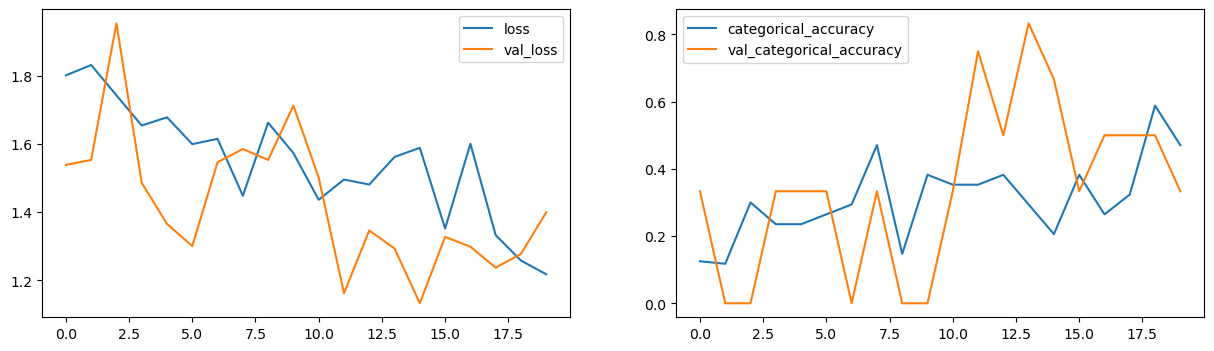

In [25]:
plot(history)

In [143]:
!tar -zcvf mobileneth5filesvalid.tar.gz /kaggle/working/mobile_net_2023-06-2809_58_55.251886/model-00015-0.04679-0.99308-0.06921-0.96667.h5

tar: Removing leading `/' from member names
/kaggle/working/mobile_net_2023-06-2809_58_55.251886/model-00015-0.04679-0.99308-0.06921-0.96667.h5


In [141]:
!tar -zcvf mobileneth5files2.tar.gz /kaggle/working/mobile_net_2023-06-2809_20_52.013283

tar: Removing leading `/' from member names
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/model-00008-1.50149-0.44118-1.10940-0.66667.h5
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/model-00019-0.88913-0.70588-0.70182-0.50000.h5
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/model-00005-1.55105-0.26471-1.29745-0.33333.h5
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/model-00006-1.44909-0.32353-1.23424-0.66667.h5
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/model-00009-1.48897-0.35294-0.81689-1.00000.h5
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/model-00001-1.75280-0.21429-1.76270-0.23810.h5
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/model-00004-1.53564-0.35294-1.42898-0.66667.h5
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/model-00020-1.04148-0.55882-0.63189-0.83333.h5
/kaggle/working/mobile_net_2023-06-2809_20_52.013283/model-00001-1.68639-0.19643-1.50601-0.26190.h5
/k